<a href="https://colab.research.google.com/github/sagawritescode/ENDTwoPointOPhase1/blob/main/ERA_V1_Assignment_8_Group_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

Data Download and Transformations

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13120819.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Inspect the dataset

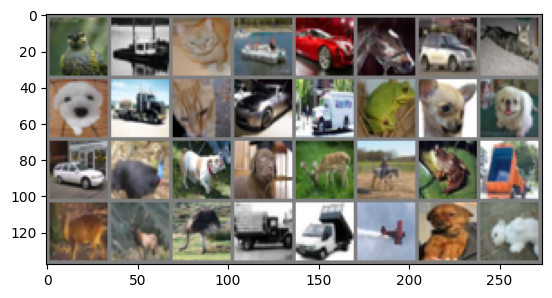

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Model Initialisation and Summary

In [5]:
!pip install torchsummary
from torchsummary import summary
from model import GroupNormalisationModel
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = GroupNormalisationModel(4).to(device)
summary(model, input_size=(3, 32, 32))

bird  ship  cat   ship  car   horse car   cat   dog   truck cat   car   truck frog  dog   dog   car   bird  dog   dog   deer  horse frog  truck deer  deer  bird  truck truck plane dog   dog  
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 34, 34]             512

Define Train and Test Functions

In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    iterator_count = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_comparisons = pred.eq(target.view_as(pred))
            correct += pred_comparisons.sum().item()

            ## code to store misclassfied images
            predictions = pred_comparisons.squeeze()
            pred = pred.squeeze()
            target = (target.view_as(pred)).squeeze()
            index = 0
            if len(misclassified_images) < 10:
                for prediction in predictions:
                    if prediction.item() is False:

                        misclassified_images.append((data[index], pred[index].item(), target[index].item()))
                        break
                    index += 1

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Learning (And Simultaneous Evaluation) Begins!

In [7]:
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.2285888195037842 Batch_id=1562 Accuracy=38.03: 100%|██████████| 1563/1563 [00:21<00:00, 73.96it/s]



Test set: Average loss: 1.3844, Accuracy: 4946/10000 (49.46%)

EPOCH: 1


Loss=1.5367655754089355 Batch_id=1562 Accuracy=51.26: 100%|██████████| 1563/1563 [00:17<00:00, 87.89it/s]



Test set: Average loss: 1.2421, Accuracy: 5458/10000 (54.58%)

EPOCH: 2


Loss=0.7359757423400879 Batch_id=1562 Accuracy=58.05: 100%|██████████| 1563/1563 [00:18<00:00, 84.72it/s]



Test set: Average loss: 1.0779, Accuracy: 6126/10000 (61.26%)

EPOCH: 3


Loss=0.5989051461219788 Batch_id=1562 Accuracy=61.98: 100%|██████████| 1563/1563 [00:17<00:00, 88.89it/s]



Test set: Average loss: 1.0307, Accuracy: 6374/10000 (63.74%)

EPOCH: 4


Loss=1.579458475112915 Batch_id=1562 Accuracy=64.74: 100%|██████████| 1563/1563 [00:17<00:00, 86.84it/s]



Test set: Average loss: 0.9860, Accuracy: 6471/10000 (64.71%)

EPOCH: 5


Loss=0.5859604477882385 Batch_id=1562 Accuracy=66.89: 100%|██████████| 1563/1563 [00:18<00:00, 85.61it/s]



Test set: Average loss: 0.8966, Accuracy: 6831/10000 (68.31%)

EPOCH: 6


Loss=1.0268166065216064 Batch_id=1562 Accuracy=71.44: 100%|██████████| 1563/1563 [00:17<00:00, 87.31it/s]



Test set: Average loss: 0.8328, Accuracy: 7069/10000 (70.69%)

EPOCH: 7


Loss=0.6263942718505859 Batch_id=1562 Accuracy=72.16: 100%|██████████| 1563/1563 [00:18<00:00, 83.74it/s]



Test set: Average loss: 0.8076, Accuracy: 7170/10000 (71.70%)

EPOCH: 8


Loss=0.6748460531234741 Batch_id=1562 Accuracy=72.58: 100%|██████████| 1563/1563 [00:18<00:00, 85.58it/s]



Test set: Average loss: 0.8093, Accuracy: 7175/10000 (71.75%)

EPOCH: 9


Loss=0.3038792014122009 Batch_id=1562 Accuracy=72.99: 100%|██████████| 1563/1563 [00:18<00:00, 86.74it/s]



Test set: Average loss: 0.8072, Accuracy: 7170/10000 (71.70%)

EPOCH: 10


Loss=0.7286233901977539 Batch_id=1562 Accuracy=73.13: 100%|██████████| 1563/1563 [00:17<00:00, 87.15it/s]



Test set: Average loss: 0.7971, Accuracy: 7219/10000 (72.19%)

EPOCH: 11


Loss=1.0725741386413574 Batch_id=1562 Accuracy=73.29: 100%|██████████| 1563/1563 [00:17<00:00, 87.97it/s]



Test set: Average loss: 0.8214, Accuracy: 7120/10000 (71.20%)

EPOCH: 12


Loss=1.0488383769989014 Batch_id=1562 Accuracy=74.00: 100%|██████████| 1563/1563 [00:18<00:00, 85.98it/s]



Test set: Average loss: 0.7898, Accuracy: 7231/10000 (72.31%)

EPOCH: 13


Loss=1.1041038036346436 Batch_id=1562 Accuracy=74.01: 100%|██████████| 1563/1563 [00:18<00:00, 85.33it/s]



Test set: Average loss: 0.7808, Accuracy: 7263/10000 (72.63%)

EPOCH: 14


Loss=0.981707751750946 Batch_id=1562 Accuracy=74.04: 100%|██████████| 1563/1563 [00:18<00:00, 86.57it/s]



Test set: Average loss: 0.7855, Accuracy: 7239/10000 (72.39%)



Display misclassified images

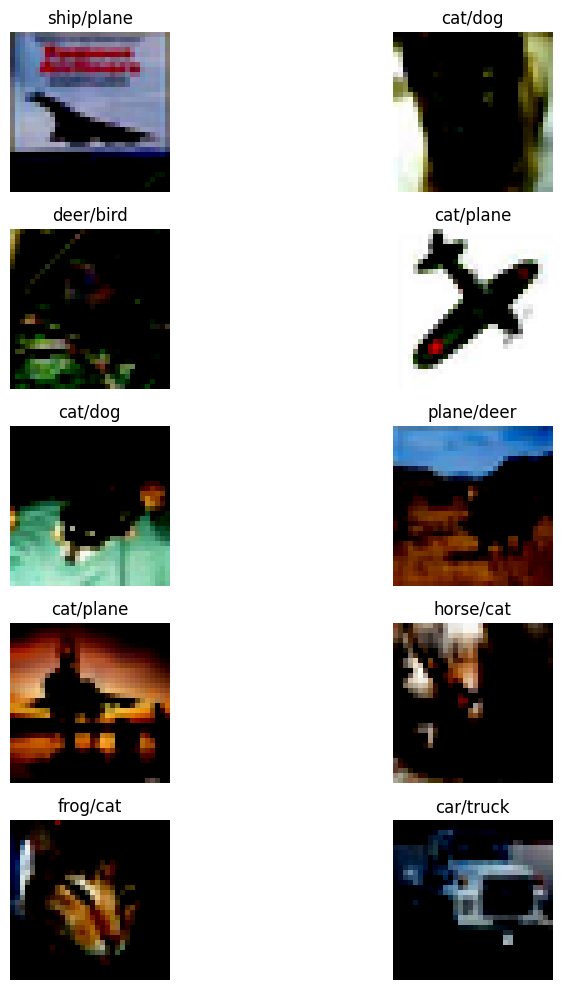

In [8]:
def denormalise_image(normalized_image):
    denormalize = transforms.Normalize((-1, -1, -1), (2, 2, 2))

    # Denormalize the image
    denormalized_image = denormalize(normalized_image)

    # Convert the tensor to a numpy array
    denormalized_image = denormalized_image.cpu().numpy()

    # Convert the image from range [-1, 1] to [0, 1]
    denormalized_image = (denormalized_image + 1) / 2

    return denormalized_image

denormalised_images = []
for image, pred, target in misclassified_images:
    denormalised_images.append((denormalise_image(image), pred, target))


fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i in range(5):
    for j in range(2):
        misclassified_image = misclassified_images[i * 2 + j]
        image = misclassified_image[0].cpu().numpy()
        axes[i, j].imshow(np.transpose(image, (1, 2, 0)))
        axes[i, j].axis('off')

        axes[i, j].set_title(f'{classes[misclassified_image[1]]}/{classes[misclassified_image[2]]}')
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Test Accuracy')

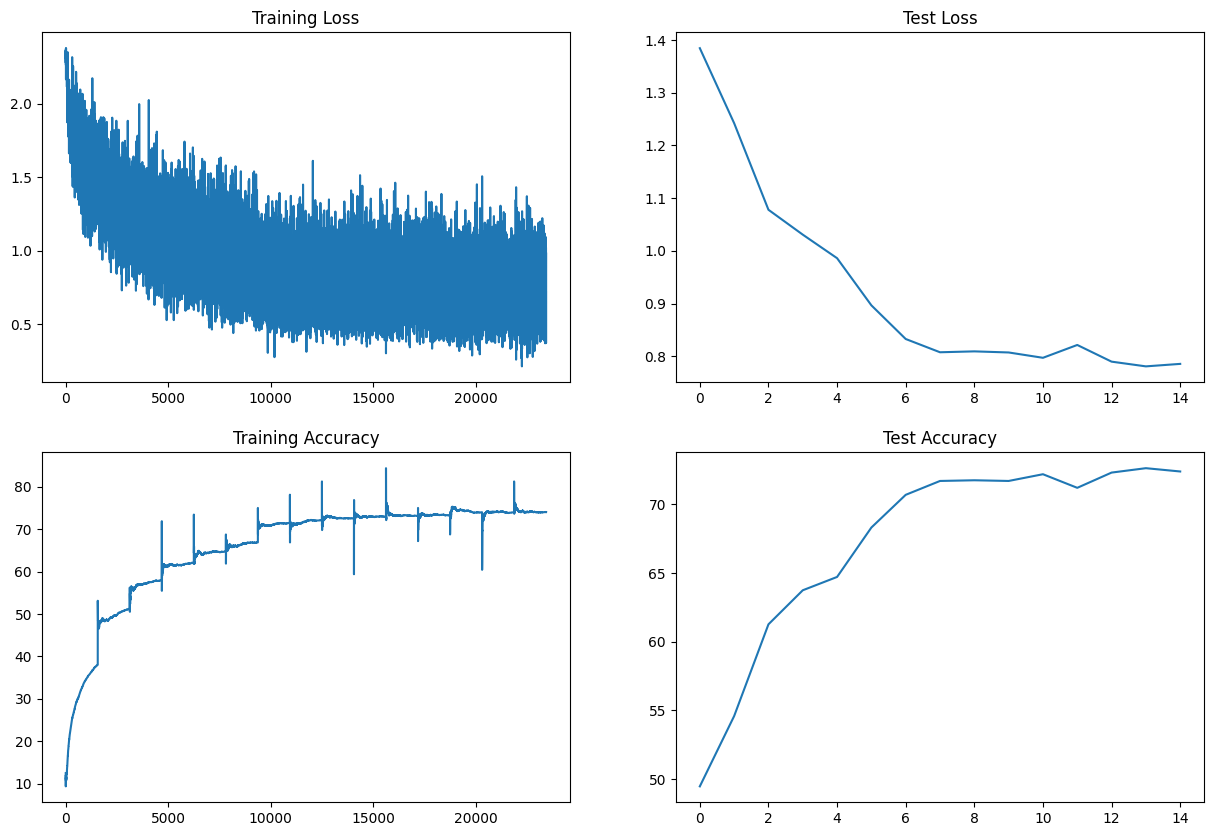

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
print(type(axs))
t = [t_items.item() for t_items in train_losses]
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")